In [2]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import fitsio
import desimodel.io
import desitarget.mtl
from desitarget.targetmask import desi_mask, obsconditions

%matplotlib inline

In [3]:
path_to_targets = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/'
target_files = glob.glob(os.path.join(path_to_targets, "targets*fits"))
print(len(target_files))
target_files.sort()
print(target_files)

32
['/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-0,63.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-1,5,11,50,55,60,83,84,86,89,91,98,119,155,158,174,186,187,190.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-10,66,69,75,87,105.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-13,15.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-16,81,99,104,106,107,176.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-17,34,92,142,181,191.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-18,45,46.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-19,37,40.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/ma

In [4]:
data = fitsio.FITS(target_files[0], 'r')
target_data = data[1].read(columns=['TARGETID', 'DESI_TARGET', 'MWS_TARGET', 'BGS_TARGET', 'SUBPRIORITY', 'NUMOBS_INIT', 'PRIORITY_INIT', 'RA', 'DEC', 'HPXPIXEL'])
data.close()
for i, i_name in enumerate(target_files[1:]):
    data = fitsio.FITS(i_name, 'r')
    tmp_data = data[1].read(columns=['TARGETID', 'DESI_TARGET', 'MWS_TARGET', 'BGS_TARGET', 'SUBPRIORITY', 'NUMOBS_INIT', 'PRIORITY_INIT', 'RA', 'DEC', 'HPXPIXEL'])
    target_data = np.hstack((target_data, tmp_data))
    data.close()
    print(i, len(target_files), len(tmp_data))

0 32 256289
1 32 4532582
2 32 20
3 32 5003715
4 32 5584769
5 32 3907729
6 32 3946378
7 32 5699127
8 32 4382367
9 32 3507499
10 32 3440441
11 32 3427727
12 32 4618152
13 32 4678745
14 32 5015385
15 32 3453631
16 32 7537070
17 32 4531487
18 32 3953483
19 32 1567757
20 32 3873054
21 32 5267424
22 32 2020765
23 32 4596113
24 32 4776432
25 32 4457068
26 32 3957455
27 32 4262977
28 32 4789174
29 32 4479744
30 32 1100824


In [5]:
len(target_data)

123285320

In [6]:
mtl = desitarget.mtl.make_mtl(target_data)

INFO:mtl.py:119:make_mtl: 285053 of 123285320 targets have priority zero, setting N_obs=0.


123285320
12381


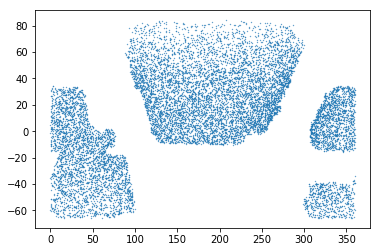

In [7]:
n_targets = len(mtl)
print(n_targets)
r = np.random.random(n_targets)
rr = r<0.0001
print(np.count_nonzero(rr))
mini_mtl = mtl[rr]
plt.scatter(mini_mtl['RA'], mini_mtl['DEC'], s=0.1)

In [8]:
set(mini_mtl['OBSCONDITIONS'])

{1, 3, 4, 5, 7}

In [9]:
tiles = desimodel.io.load_tiles()
ii_bright = (tiles['OBSCONDITIONS'] & obsconditions.BRIGHT)!=0
print(set(tiles['PROGRAM'][ii_bright]))
print(set(tiles['PROGRAM'][~ii_bright]))
ii_south = (tiles['RA']<80) | (tiles['RA']>300)
ii_north = (tiles['RA']>80) & (tiles['RA']<300)
Table(tiles[ii_bright]).write('tiles_bright_time.fits', overwrite=True)
Table(tiles[~ii_bright & ii_south]).write('tiles_dark_gray_time_south.fits', overwrite=True)
Table(tiles[~ii_bright & ii_north]).write('tiles_dark_gray_time_north.fits', overwrite=True)

{'BRIGHT'}
{'DARK', 'GRAY'}


In [10]:
ii_mtl_bright = (mtl['OBSCONDITIONS'] & obsconditions.BRIGHT)!=0
ii_inside = (mtl['DEC']>-20)
mtl_bright_file = 'dr8_mtl_bright.fits'
mtl[ii_mtl_bright&ii_inside].write(mtl_bright_file, overwrite=True)

In [17]:
mtl_dark_file_north = 'dr8_mtl_dark_gray_northern_cap.fits'
mtl_dark_file_south = 'dr8_mtl_dark_gray_southern_cap.fits'

ii_mtl_dark = (mtl['OBSCONDITIONS'] & obsconditions.DARK)!=0
ii_mtl_gray = (mtl['OBSCONDITIONS'] & obsconditions.GRAY)!=0
ii_inside = (mtl['DEC']>-20)
ii_south = (mtl['RA']<85) | (mtl['RA']>300)
ii_north = (mtl['RA']>85) & (mtl['RA']<300) & (mtl['DEC']>-15)

mtl[(ii_mtl_dark | ii_mtl_gray)&ii_inside&ii_south].write(mtl_dark_file_south, overwrite=True)
mtl[(ii_mtl_dark | ii_mtl_gray)&ii_inside&ii_north].write(mtl_dark_file_north, overwrite=True)


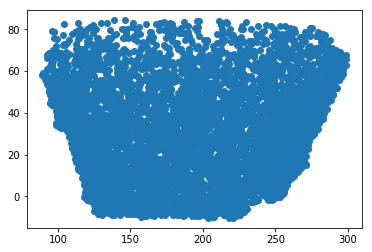

In [18]:
mtl_north = Table.read(mtl_dark_file_north)
n_points = len(mtl_north)
r = np.random.random(n_points)
rr = r<0.0001
plt.scatter(mtl_north['RA'][rr], mtl_north['DEC'][rr])

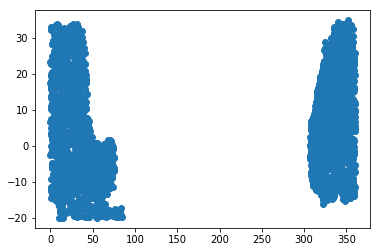

In [19]:
mtl_south = Table.read(mtl_dark_file_south)
n_points = len(mtl_south)
r = np.random.random(n_points)
rr = r<0.0001
plt.scatter(mtl_south['RA'][rr], mtl_south['DEC'][rr])

6958


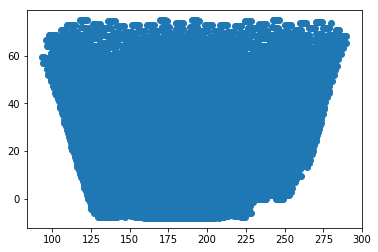

In [24]:
tiles_bright = Table.read('tiles_dark_gray_time_north.fits')
print(len(tiles_bright))
plt.scatter(tiles_bright['RA'], tiles_bright['DEC'])
ii = (tiles_bright['RA']<80) | (tiles_bright['RA']>300)
jj = (tiles_bright['RA']>80) & (tiles_bright['RA']<300)

#plt.scatter(tiles_bright['RA'][ii], tiles_bright['DEC'][ii])
#plt.scatter(tiles_bright['RA'][jj], tiles_bright['DEC'][jj])

In [43]:
tile = Table.read("/global/cscratch1/sd/forero/fiberassign_explore/dark_south_fiberassign/fiberassign_000027.fits")

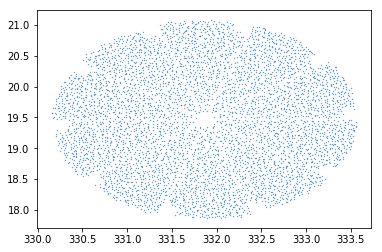

In [44]:
plt.scatter(tile['TARGET_RA'], tile['TARGET_DEC'], s=0.1)

In [40]:
set(tile['MWS_TARGET'])

{0, 2, 4, 6, 33, 37, 1280, 1286, 10240}